In [1]:
%load_ext rpy2.ipython
%matplotlib inline
from fbprophet import Prophet
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
df = pd.read_csv('../examples/example_wp_peyton_manning.csv')
df['y'] = np.log(df['y'])
m = Prophet()
m.fit(df)
future = m.make_future_dataframe(periods=366)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [2]:
%%R
library(prophet)
df <- read.csv('../examples/example_wp_peyton_manning.csv')
df$y <- log(df$y)
m <- prophet(df)
future <- make_future_dataframe(m, periods=366)

/usr/local/lib/python2.7/dist-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: Rcpp

  warnings.warn(x, RRuntimeWarning)


Initial log joint probability = -19.4685
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


### Specifying Seasonalities

Prophet will by default fit weekly and yearly seasonalities, if the time series is more than two cycles long. It will also fit daily seasonality for a sub-daily time series. You can add other seasonalities (monthly, quarterly, hourly) using the `add_seasonality` method (Python) or function (R).

The inputs to this function are a name, the period of the seasonality in days, and the number of Fourier terms for the seasonality. Increasing the number of Fourier terms allows the seasonality to fit faster changing cycles, but can also lead to overfitting: $N$ Fourier terms corresponds to $2N$ variables used for modeling the cycle. For reference, by default Prophet uses 3 terms for weekly seasonality and 10 for yearly seasonality.

As an example, here we fit the Peyton Manning data from the Quickstart, but replace the weekly seasonality with monthly seasonality:

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


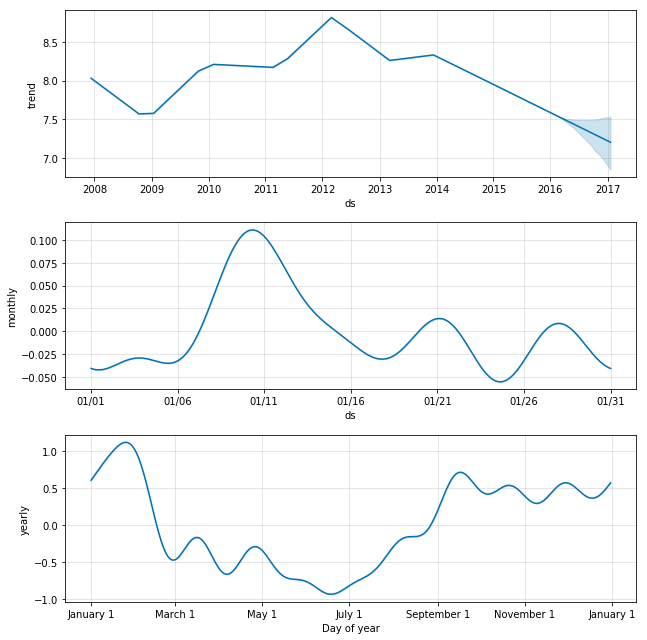

In [3]:
m = Prophet(weekly_seasonality=False)
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
forecast = m.fit(df).predict(future)
m.plot_components(forecast);

Initial log joint probability = -19.4685
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


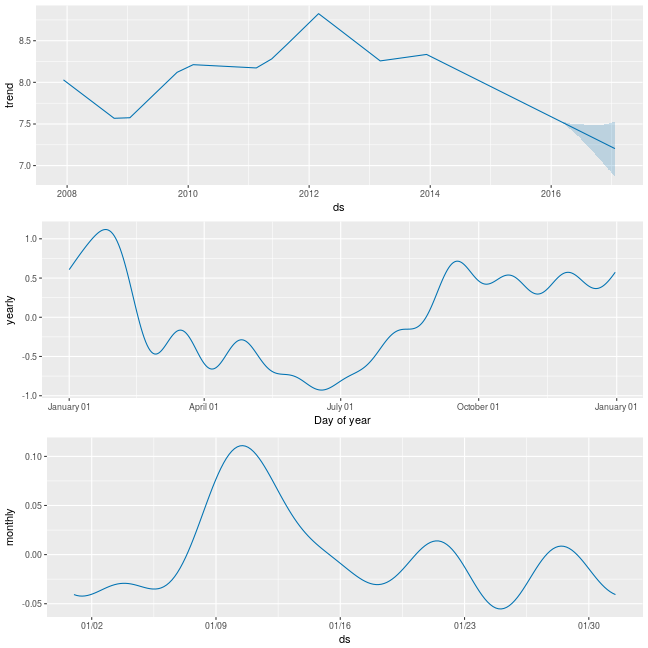

In [4]:
%%R -w 9 -h 9 -u in
m <- prophet(weekly.seasonality=FALSE)
m <- add_seasonality(m, name='monthly', period=30.5, fourier.order=5)
m <- fit.prophet(m, df)
forecast <- predict(m, future)
prophet_plot_components(m, forecast)

### Modeling Holidays
If you have holidays that you'd like to model, you must create a dataframe for them. It has two columns (`holiday` and `ds`) and a row for each occurrence of the holiday. It must include all occurrences of the holiday, both in the past (back as far as the historical data go) and in the future (out as far as the forecast is being made). If they won't repeat in the future, Prophet will model them and then not include them in the forecast.

You can also include columns `lower_window` and `upper_window` which extend the holiday out to `[lower_window, upper_window]` days around the date. For instance, if you wanted to included Christmas Eve in addition to Christmas you'd include `lower_window=-1,upper_window=0`. If you wanted to use Black Friday in addition to Thanksgiving, you'd include `lower_window=0,upper_window=1`.

Here we create a dataframe that includes the dates of all of Peyton Manning's playoff appearances:

In [5]:
playoffs = pd.DataFrame({
  'holiday': 'playoff',
  'ds': pd.to_datetime(['2008-01-13', '2009-01-03', '2010-01-16',
                        '2010-01-24', '2010-02-07', '2011-01-08',
                        '2013-01-12', '2014-01-12', '2014-01-19',
                        '2014-02-02', '2015-01-11', '2016-01-17',
                        '2016-01-24', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})
superbowls = pd.DataFrame({
  'holiday': 'superbowl',
  'ds': pd.to_datetime(['2010-02-07', '2014-02-02', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})
holidays = pd.concat((playoffs, superbowls))

In [6]:
%%R
library(dplyr)
playoffs <- data_frame(
  holiday = 'playoff',
  ds = as.Date(c('2008-01-13', '2009-01-03', '2010-01-16',
                 '2010-01-24', '2010-02-07', '2011-01-08',
                 '2013-01-12', '2014-01-12', '2014-01-19',
                 '2014-02-02', '2015-01-11', '2016-01-17',
                 '2016-01-24', '2016-02-07')),
  lower_window = 0,
  upper_window = 1
)
superbowls <- data_frame(
  holiday = 'superbowl',
  ds = as.Date(c('2010-02-07', '2014-02-02', '2016-02-07')),
  lower_window = 0,
  upper_window = 1
)
holidays <- bind_rows(playoffs, superbowls)

/usr/local/lib/python2.7/dist-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 
Attaching package: ‘dplyr’


  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python2.7/dist-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python2.7/dist-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  warnings.warn(x, RRuntimeWarning)


Above we have include the superbowl days as both playoff games and superbowl games. This means that the superbowl effect will be an additional additive bonus on top of the playoff effect.

Once the table is created, holiday effects are included in the forecast by passing them in with the `holidays` argument. Here we do it with the Peyton Manning data from the Quickstart:

In [7]:
m = Prophet(holidays=holidays)
forecast = m.fit(df).predict(future)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [8]:
%%R
m <- prophet(df, holidays = holidays)
forecast <- predict(m, future)

Initial log joint probability = -19.4685
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


The holiday effect can be seen in the `forecast` dataframe:

In [9]:
%%R
forecast %>% 
  select(ds, playoff, superbowl) %>% 
  filter(abs(playoff + superbowl) > 0) %>%
  tail(10)

           ds  playoff superbowl
17 2014-02-02 1.227333  1.190688
18 2014-02-03 1.902392  1.468285
19 2015-01-11 1.227333  0.000000
20 2015-01-12 1.902392  0.000000
21 2016-01-17 1.227333  0.000000
22 2016-01-18 1.902392  0.000000
23 2016-01-24 1.227333  0.000000
24 2016-01-25 1.902392  0.000000
25 2016-02-07 1.227333  1.190688
26 2016-02-08 1.902392  1.468285


In [10]:
forecast[(forecast['playoff'] + forecast['superbowl']).abs() > 0][
        ['ds', 'playoff', 'superbowl']][-10:]

,ds,playoff,superbowl
2190,2014-02-02,1.223214,1.213315
2191,2014-02-03,1.906370,1.412192
2532,2015-01-11,1.223214,0.000000
2533,2015-01-12,1.906370,0.000000
2901,2016-01-17,1.223214,0.000000
2902,2016-01-18,1.906370,0.000000
2908,2016-01-24,1.223214,0.000000
2909,2016-01-25,1.906370,0.000000
2922,2016-02-07,1.223214,1.213315
2923,2016-02-08,1.906370,1.412192


The holiday effects will also show up in the components plot, where we see that there is a spike on the days around playoff appearances, with an especially large spike for the superbowl:

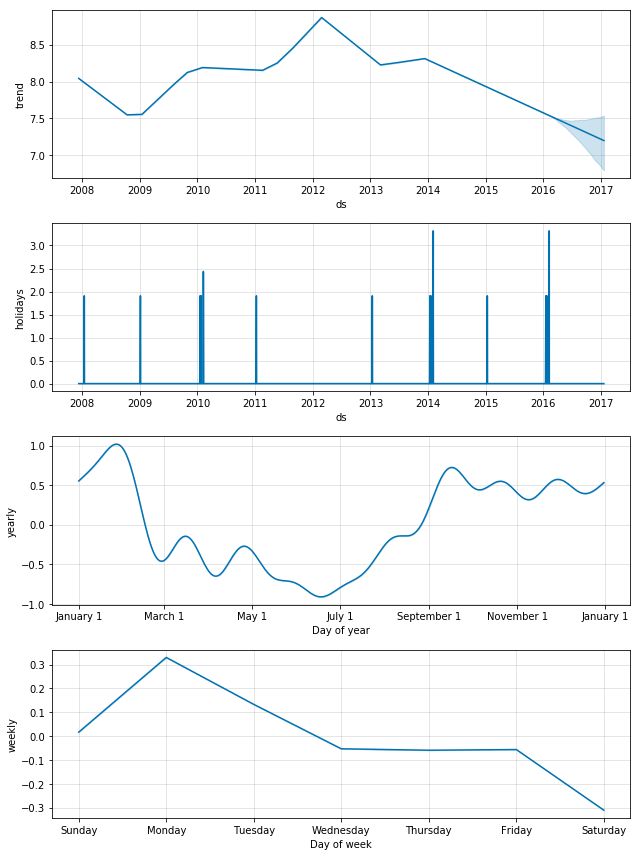

In [11]:
m.plot_components(forecast);

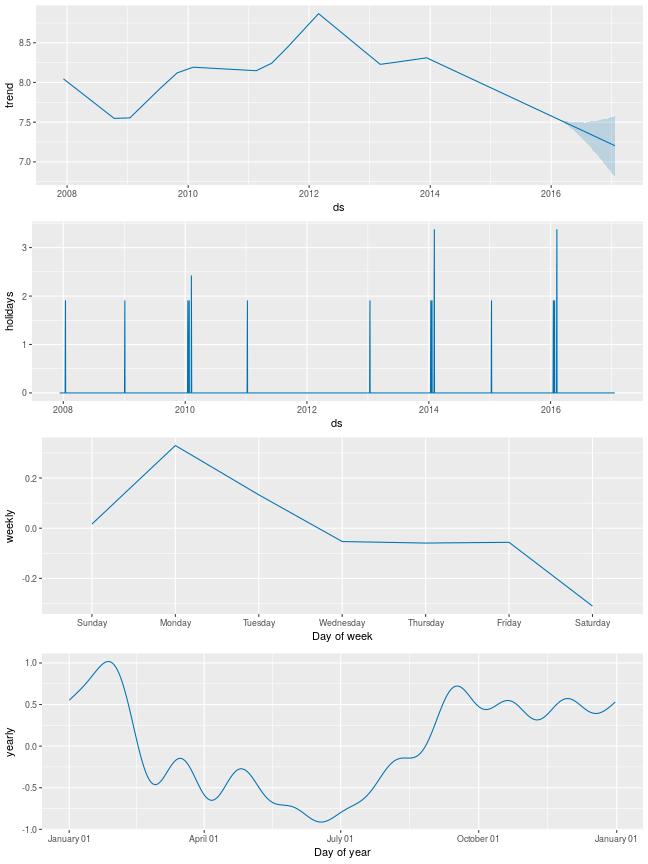

In [12]:
%%R -w 9 -h 12 -u in
prophet_plot_components(m, forecast);

### Prior scale for holidays and seasonality
If you find that the holidays are overfitting, you can adjust their prior scale to smooth them using the parameter `holidays_prior_scale`, which by default is 10:

In [13]:
%%R
m <- prophet(df, holidays = holidays, holidays.prior.scale = 1)
forecast <- predict(m, future)
forecast %>% 
  select(ds, playoff, superbowl) %>% 
  filter(abs(playoff + superbowl) > 0) %>%
  tail(10)

Initial log joint probability = -19.4685
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
           ds  playoff superbowl
17 2014-02-02 1.315141 0.7989651
18 2014-02-03 1.987399 0.6608394
19 2015-01-11 1.315141 0.0000000
20 2015-01-12 1.987399 0.0000000
21 2016-01-17 1.315141 0.0000000
22 2016-01-18 1.987399 0.0000000
23 2016-01-24 1.315141 0.0000000
24 2016-01-25 1.987399 0.0000000
25 2016-02-07 1.315141 0.7989651
26 2016-02-08 1.987399 0.6608394


In [14]:
m = Prophet(holidays=holidays, holidays_prior_scale=1).fit(df)
forecast = m.predict(future)
forecast[(forecast['playoff'] + forecast['superbowl']).abs() > 0][
    ['ds', 'playoff', 'superbowl']][-10:]

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,playoff,superbowl
2190,2014-02-02,1.330950,0.703795
2191,2014-02-03,1.991491,0.557307
2532,2015-01-11,1.330950,0.000000
2533,2015-01-12,1.991491,0.000000
2901,2016-01-17,1.330950,0.000000
2902,2016-01-18,1.991491,0.000000
2908,2016-01-24,1.330950,0.000000
2909,2016-01-25,1.991491,0.000000
2922,2016-02-07,1.330950,0.703795
2923,2016-02-08,1.991491,0.557307


The magnitude of the holiday effect has been reduced compared to before, especially for superbowls, which had the fewest observations. There is a parameter `seasonality_prior_scale` which similarly adjusts the extent to which the seasonality model will fit the data.